# Processing Data 

In this jupyter what we are looking for is to be able to process the data to obtain a prediction for days 1, 3 and 7.

In summary, first we will extract the sentiment of the tweets and then we will make a union of the two tables tweets and prices. We will use the Arimax Model and LSTM to get the predictions when the data is ready.

## Libraries for processing 

In [1]:
# Process Data
from pyspark.sql import SparkSession  # Spark Session
from pyspark.sql.functions import lit, col, sum, length, regexp_replace, explode, udf
from pyspark.sql.types import FloatType, StringType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import to_date


In [2]:
# EDA
from wordcloud import WordCloud
import re
import emoji
import string

# Sentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# General
import pandas as pd
import numpy as np

# Prediction
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Cassandra
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider


2024-12-10 23:28:26.676311: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 23:28:26.680404: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 23:28:26.692882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733873306.714762   81680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733873306.721048   81680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 23:28:26.741508: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Using Spark with Hive

Create a Spark session to connect to the hive database

In [4]:
# Configuration before creating the Spark session
spark = SparkSession.builder \
    .appName("StockTweetsToHive") \
    .enableHiveSupport() \
    .getOrCreate()

24/12/10 23:28:29 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Reading the data from Hive

We look for our previously created database

In [5]:
spark.sql("Show databases;").show()

+---------+
|namespace|
+---------+
|benchmark|
|      ca2|
|  default|
| testhive|
+---------+



We look for our previously created database

In [6]:
spark.sql("USE ca2;")

DataFrame[]

We load our tweets in a spark dataframe we load tweets 

In [7]:
tweets = spark.sql("Select * from tweets;")

In [8]:
tweets.show()
print(tweets.count())

+------+----------+------+--------------------+
|    id|      date|ticker|               tweet|
+------+----------+------+--------------------+
|100001|01/01/2020|  AMZN|$AMZN Dow futures...|
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|
|100003|01/01/2020|  AAPL|$AAPL We’ll been ...|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|
|100007|02/01/2020|  AAPL|$AAPL $300 calls ...|
|100008|02/01/2020|  AAPL|$AAPL Remember, i...|
|100009|02/01/2020|  AAPL|$AAPL called it, ...|
|100010|02/01/2020|    HD|$HD Bought more a...|
|100011|02/01/2020|  AAPL|Apple is taking t...|
|100012|02/01/2020|  AAPL|$AAPL not a bad d...|
|100013|02/01/2020|  AAPL|$AAPL where are a...|
|100014|03/01/2020|  NVDA|$NVDA This should...|
|100015|03/01/2020|  AAPL|$AAPL tomorrow bu...|
|100016|03/01/2020|  AAPL|$AAPL Thanks for ...|
|100017|03/01/2020|  AAPL|$AAPL leave enoug...|
|100018|03/01/2020|  AAPL|$AAPL short th

# EDA from tweets

## 1.- Initial display and basic description

We get only the tweets of the companies we are interested in, we have taken companies in ramdon mode.

Now let's filter and see a general description of the tweets table. 

In [9]:
# Filtrar el dataframe para las 5 compañías
tickers = ["BAC", "DIS", "PG", "TSLA", "WMT"]
tweets = tweets.filter(tweets['ticker'].isin(tickers))

In [10]:
# Show the firsts rows 
tweets.select('tweet').show(10)

# get statistic descriptive 
tweets.select('tweet').describe().show()

+--------------------+
|               tweet|
+--------------------+
|$TSLA Daddy's dri...|
|$TSLA happy new y...|
|"$TSLA haha just ...|
|$TSLA NOBODY: Gas...|
|$TSLA  I must ris...|
|$TSLA shorts are ...|
|$TSLA Don’t short...|
|$TSLA 🐻 not see ...|
|$TSLA  can one he...|
|$TSLA Ignore the ...|
+--------------------+
only showing top 10 rows

+-------+--------------------+
|summary|               tweet|
+-------+--------------------+
|  count|                4959|
|   mean|                null|
| stddev|                null|
|    min| Bummer that $TSL...|
|    max|🚨🔥☆☆☆ $TSLA ☆☆☆...|
+-------+--------------------+



## 2.- Review of null or empty values

We check for null values, in this case there are no null values.

In [11]:
# Count null or empty values in the column 'tweet'.
tweets.filter(tweets['tweet'].isNull()).count()
tweets.filter(tweets['tweet'] == '').count()


0

## 3.- Length of tweets

In [12]:
# Calculate the length of the tweets
df_with_length_filtered = tweets.withColumn("tweet_length", length(tweets['tweet']))

# Statistics on the length of the tweets
df_with_length_filtered.select('tweet_length').describe().show()

# Show tweets with extreme length
df_with_length_filtered.filter(df_with_length_filtered['tweet_length'] > 200).show(10)  # Example for tweets longer than 200 characters


+-------+-----------------+
|summary|     tweet_length|
+-------+-----------------+
|  count|             4959|
|   mean|81.52046783625731|
| stddev|46.21096124505679|
|    min|               23|
|    max|              255|
+-------+-----------------+

+------+----------+------+--------------------+------------+
|    id|      date|ticker|               tweet|tweet_length|
+------+----------+------+--------------------+------------+
|100047|07/01/2020|  TSLA|$TSLA bears 🐻 I ...|         235|
|100064|08/01/2020|   DIS|$DIS small piece ...|         237|
|100250|22/01/2020|  TSLA|$TSLA y’all need ...|         223|
|100279|23/01/2020|  TSLA|$TSLA If someone ...|         224|
|100308|24/01/2020|  TSLA|$TSLA lol its so ...|         237|
|100322|28/01/2020|  TSLA|$TSLA there'san e...|         234|
|100473|03/02/2020|  TSLA|$TSLA Unbelievabl...|         222|
|100594|06/02/2020|  TSLA|$TSLA i am going ...|         244|
|100733|13/02/2020|  TSLA|$TSLA i freaking ...|         215|
|100874|24/02/20

## 4.- Word frequency

We will show the most frequently occurring words in all tweets in order to explore the data in a general way.

In [13]:
from pyspark.sql.functions import regexp_replace, split, explode

# Clean the tweets (remove non-alphanumeric characters) and split into words
df_cleaned = tweets.withColumn("cleaned_tweet", regexp_replace("tweet", "[^a-zA-Z\\s]", ""))
df_tokenized = df_cleaned.withColumn("words", split(col("cleaned_tweet"), "\\s+"))

# Exploding the words and counting occurrences
word_count = df_tokenized.withColumn("word", explode(df_tokenized['words'])) \
                         .groupBy("word").count() \
                         .orderBy(col('count').desc())

# Show the top 10 most frequent words
word_count.show(10)


+----+-----+
|word|count|
+----+-----+
|TSLA| 4395|
|    | 3463|
| the| 1927|
|  to| 1769|
|   a| 1172|
|this|  997|
|  is|  956|
| and|  930|
|   I|  881|
|  in|  723|
+----+-----+
only showing top 10 rows



## 5.- Word cloud 

We only show interactively the words that appear more in tweets according to frequency

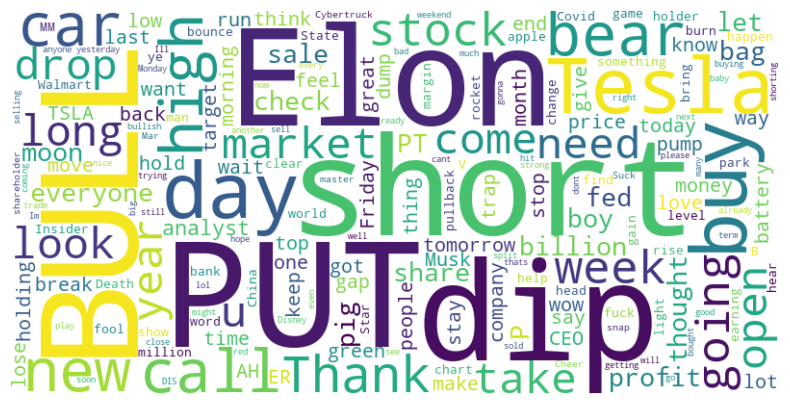

In [14]:
# Get the most frequent words for the 5 companies
#words_filtered = word_count_filtered.toPandas()
words_filtered = word_count.toPandas()
words_str_filtered = ' '.join(words_filtered['word'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(words_str_filtered)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## 6.- Text cleaning

We have created a function to clean up the text we pass to it, and we have specified the type of cleaning for informal text 

In [15]:
# Function to clean text
def clean_text(tweet):
    # Remove emojis
    tweet = emoji.replace_emoji(tweet, replace='')  # Removes the emojis

    # Remove user mentions (words that start with '@')
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # Remove hashtags (if you don't want to keep the hashtags)
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers (if they are not relevant for the analysis)
    tweet = re.sub(r'\d+', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

# Convert the function into a UDF for PySpark
clean_text_udf = udf(clean_text, StringType())


We call the function to clean and display the original text and the cleaned text.

In [16]:
# Remove mentions (@user) and links (http://...)
df_cleaned = tweets.withColumn("cleaned_tweet", clean_text_udf(tweets['tweet']))

# Show cleaned tweets
df_cleaned.select('tweet','cleaned_tweet').show(20)


+--------------------+--------------------+
|               tweet|       cleaned_tweet|
+--------------------+--------------------+
|$TSLA Daddy's dri...|tsla daddys drink...|
|$TSLA happy new y...|tsla happy new ye...|
|"$TSLA haha just ...|tsla haha just a ...|
|$TSLA NOBODY: Gas...|tsla nobody gas c...|
|$TSLA  I must ris...|tsla i must rise ...|
|$TSLA shorts are ...|tsla shorts are f...|
|$TSLA Don’t short...|tsla don’t short ...|
|$TSLA 🐻 not see ...|tsla not see anyt...|
|$TSLA  can one he...|tsla can one hear...|
|$TSLA Ignore the ...|tsla ignore the c...|
|$TSLA  Squeal lik...|tsla squeal like ...|
|$TSLA shorts thou...|tsla shorts thoug...|
|$TSLA if you had ...|tsla if you had o...|
|Once again $TSLA ...|once again tsla k...|
|$TSLA BUT BUTT WW...|tsla but butt ww ...|
|$TSLA Congratulat...|tsla congratulati...|
|$TSLA these bears...|tsla these bears ...|
|$TSLA Top of the ...|tsla top of the c...|
|$TSLA wow jpm wit...|tsla wow jpm with...|
|$DIS Just keep fa...|dis just ke

# Sentiment analysis for Tweets

To make the sentiment we have implemented 2 options, one using the TextBlob library and the other one using Vader as follows

### Implementation Textblob

In [17]:
# Function to analyze sentiment using TextBlob
def analyze_sentiment(text):
    try:
        blob = TextBlob(text)
        # Polarity: -1 (negative) to 1 (positive)
        return blob.sentiment.polarity
    except Exception as e:
        return None

# Create a UDF (User Defined Function) in PySpark to apply sentiment analysis
sentiment_udf = udf(analyze_sentiment, FloatType())

# Apply sentiment analysis on the 'tweet' column for the 5 companies
df_sentiment = df_cleaned.withColumn('sentiment', sentiment_udf(df_cleaned['tweet']))

# Show the first rows with the calculated sentiment
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+----------+
|               tweet| sentiment|
+--------------------+----------+
|$TSLA Daddy's dri...|   0.15625|
|$TSLA happy new y...|0.46818182|
|"$TSLA haha just ...|       0.5|
|$TSLA NOBODY: Gas...|      -0.2|
|$TSLA  I must ris...|       0.5|
|$TSLA shorts are ...|       0.0|
|$TSLA Don’t short...|       0.4|
|$TSLA 🐻 not see ...|      0.05|
|$TSLA  can one he...|       0.0|
|$TSLA Ignore the ...|       1.0|
+--------------------+----------+
only showing top 10 rows



### Implementation Vader

In [18]:
# Initialize the VADER analyzer
analyzer = SentimentIntensityAnalyzer()

In [19]:
# Function to calculate sentiment using VADER
def get_sentiment(tweet):
    sentiment_score = analyzer.polarity_scores(tweet)
    return sentiment_score['compound']  # The 'compound' key is the overall polarity

# Convert the function into a PySpark UDF
sentiment_udf = udf(get_sentiment, FloatType())

In [20]:
# Apply sentiment analysis to the 'tweet' column
df_sentiment = tweets.withColumn("sentiment", sentiment_udf(tweets['tweet']))

# Show the first results with the calculated sentiment
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+---------+
|               tweet|sentiment|
+--------------------+---------+
|$TSLA Daddy's dri...|      0.0|
|$TSLA happy new y...|   0.7506|
|"$TSLA haha just ...|   0.9371|
|$TSLA NOBODY: Gas...|  -0.9588|
|$TSLA  I must ris...|   0.9876|
|$TSLA shorts are ...|  -0.4939|
|$TSLA Don’t short...|   0.5267|
|$TSLA 🐻 not see ...|  -0.2755|
|$TSLA  can one he...|   0.7184|
|$TSLA Ignore the ...|   0.7256|
+--------------------+---------+
only showing top 10 rows



I choosen Vader, because is more for informal text. Also I have checked manually some text and for sure Vader es Better than TextBlob for tweets

### Categorizate 

Now for a better representation of the values we will create a sentiment category column to show textually the sentiment of the tweet.

In [21]:
# Function to categorize sentiment
def sentiment_category(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Create a UDF to apply the categorization
sentiment_category_udf = udf(sentiment_category, StringType())

# Add the column with the sentiment category
df_sentiment_with_category = df_sentiment.withColumn('sentiment_category', sentiment_category_udf(df_sentiment['sentiment']))

# Show the first rows with the sentiment category
df_sentiment_with_category.select('tweet', 'sentiment', 'sentiment_category').show(10)


+--------------------+---------+------------------+
|               tweet|sentiment|sentiment_category|
+--------------------+---------+------------------+
|$TSLA Daddy's dri...|      0.0|           neutral|
|$TSLA happy new y...|   0.7506|          positive|
|"$TSLA haha just ...|   0.9371|          positive|
|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|$TSLA  I must ris...|   0.9876|          positive|
|$TSLA shorts are ...|  -0.4939|          negative|
|$TSLA Don’t short...|   0.5267|          positive|
|$TSLA 🐻 not see ...|  -0.2755|          negative|
|$TSLA  can one he...|   0.7184|          positive|
|$TSLA Ignore the ...|   0.7256|          positive|
+--------------------+---------+------------------+
only showing top 10 rows



### Length distribution of tweets (Visualization)

I will now show the distributions of the distribution categories by company in a table.

In [22]:
# Group by 'ticker' and calculate the average of 'sentiment' and the count of each sentiment category
sentiment_stats = df_sentiment_with_category.groupBy('ticker', 'sentiment_category') \
    .count() \
    .orderBy('ticker', 'sentiment_category')

# Show sentiment statistics by ticker
sentiment_stats.show()


+------+------------------+-----+
|ticker|sentiment_category|count|
+------+------------------+-----+
|   BAC|          negative|   15|
|   BAC|           neutral|   19|
|   BAC|          positive|   31|
|   DIS|          negative|  103|
|   DIS|           neutral|   89|
|   DIS|          positive|  240|
|    PG|          negative|    2|
|    PG|          positive|    1|
|  TSLA|          negative|  817|
|  TSLA|           neutral|  856|
|  TSLA|          positive| 2668|
|   WMT|          negative|   27|
|   WMT|           neutral|   27|
|   WMT|          positive|   64|
+------+------------------+-----+



I will now plot the table to better visualize the distributions of sentiments 

In [23]:
def show_distribution_tweets(data, title): 
    # Convert the Spark dataframe to pandas for plotting
    #pandas_df_sentiment = df_sentiment_with_category.toPandas()
    pandas_df_sentiment = data
    
    # Plot the distribution of sentiments by ticker
    plt.figure(figsize=(10, 6))
    sns.countplot(x='ticker', hue='sentiment_category', data=pandas_df_sentiment)
    plt.title(title)
    plt.xlabel("Companies")
    plt.ylabel("Number of Tweets")
    plt.show()


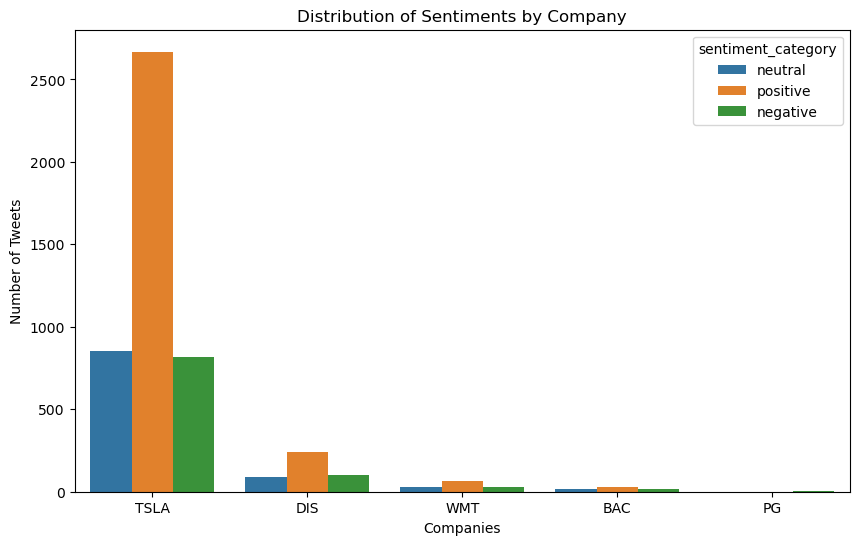

In [24]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company")

# Processing Tweets

While we have seen the sentiment for each category in each company, we have to check if there may be tweets on the same date, and if that is the case we should average the tweets of the day to place a single sentiment per day.

In [25]:
df_sentiment_with_category.select('*').show(10)

+------+----------+------+--------------------+---------+------------------+
|    id|      date|ticker|               tweet|sentiment|sentiment_category|
+------+----------+------+--------------------+---------+------------------+
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|      0.0|           neutral|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|   0.7506|          positive|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|   0.9371|          positive|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|100019|03/01/2020|  TSLA|$TSLA  I must ris...|   0.9876|          positive|
|100020|03/01/2020|  TSLA|$TSLA shorts are ...|  -0.4939|          negative|
|100021|03/01/2020|  TSLA|$TSLA Don’t short...|   0.5267|          positive|
|100023|03/01/2020|  TSLA|$TSLA 🐻 not see ...|  -0.2755|          negative|
|100024|03/01/2020|  TSLA|$TSLA  can one he...|   0.7184|          positive|
|100025|03/01/2020|  TSLA|$TSLA Ignore the ...|   0.7256|          positive|


Selecting only important columns


In [26]:
df_setiment_final = df_sentiment_with_category.select('date', 'ticker', 'sentiment','sentiment_category')
df_setiment_final.show(5)
print(df_sentiment.count())

+----------+------+---------+------------------+
|      date|ticker|sentiment|sentiment_category|
+----------+------+---------+------------------+
|01/01/2020|  TSLA|      0.0|           neutral|
|01/01/2020|  TSLA|   0.7506|          positive|
|01/01/2020|  TSLA|   0.9371|          positive|
|01/01/2020|  TSLA|  -0.9588|          negative|
|03/01/2020|  TSLA|   0.9876|          positive|
+----------+------+---------+------------------+
only showing top 5 rows

4959


Grouping register with the same date and company

In [27]:
# Group by 'date' and 'ticker' and calculate the average sentiment.
df_sentiment_avg = df_setiment_final.groupBy('date', 'ticker') \
    .agg(
        F.avg('sentiment').alias('sentiment')
    )

df_sentiment_avg.show(5)


+----------+------+------------------+
|      date|ticker|         sentiment|
+----------+------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|
|03/02/2020|  TSLA|0.4597533330321312|
|31/03/2020|   WMT|             0.875|
|01/07/2020|  TSLA| 0.248860003054142|
|03/11/2020|   WMT| 0.769599974155426|
+----------+------+------------------+
only showing top 5 rows



In [28]:
# Classify the sentiment based on the average value
df_sentiment_final = df_sentiment_avg.withColumn(
    'sentiment_category',
    F.when(df_sentiment_avg['sentiment'] > 0, 'Positive')
    .when(df_sentiment_avg['sentiment'] < 0, 'Negative')
    .otherwise('Neutral')
)

# Show the result
df_sentiment_final.show(5)
print(df_sentiment_final.count())


+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|          Positive|
|03/02/2020|  TSLA|0.4597533330321312|          Positive|
|31/03/2020|   WMT|             0.875|          Positive|
|01/07/2020|  TSLA| 0.248860003054142|          Positive|
|03/11/2020|   WMT| 0.769599974155426|          Positive|
+----------+------+------------------+------------------+
only showing top 5 rows

534


Distribucion por fecha y empresa

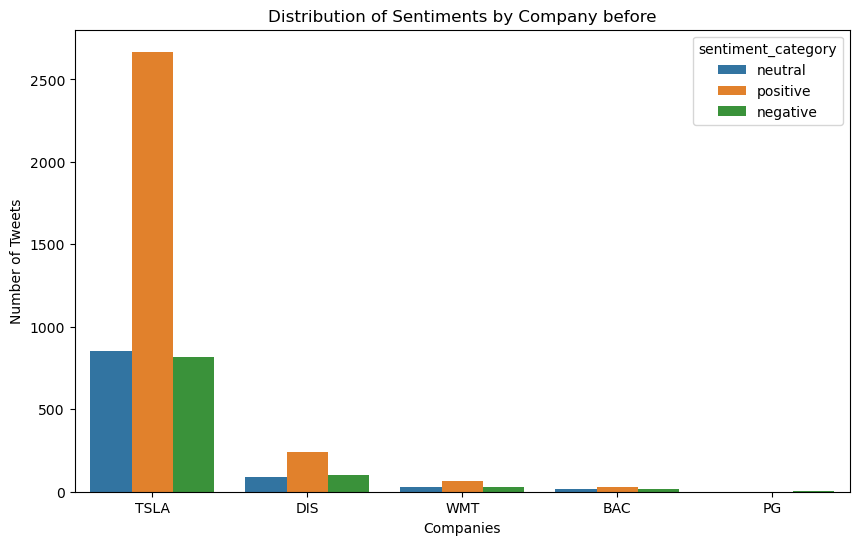

In [29]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company before")

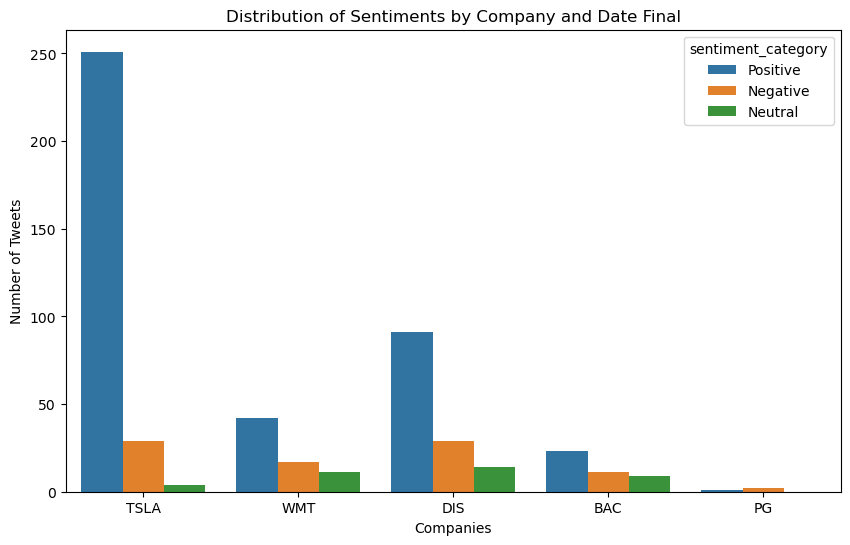

In [30]:
show_distribution_tweets(df_sentiment_final.toPandas(), "Distribution of Sentiments by Company and Date Final")

We have finished cleaning and analyzing the tweets.

# Processing Prices

Next, it is time to process the closing price of the shares. For that we will obtain from the database the records of the prices table.

In [31]:
prices = spark.sql("Select * from prices;")
prices.show(5)
print(prices.count())

+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|29.534000396728516|266677500|   TSLA|
|2020-01-06|29.364667892456055|30.104000091552734|29.333332061767578|  30.1026668548584|  30.1026668548584|151995000|   TSLA|
|2020-01-07|30.760000228881836|31.441999435424805|30.224000930786133|31.270666122436523|31.270666122436523|268231500| 

We eliminate the columns that are of interest to us in order to perform a better analysis.

# Drop columns 
prices = prices[['Date', 'Close', 'Volume', 'company']]  # Keep only the columns you need
prices.show(5)
print(prices.count())

## Join Data

Before performing the join we must make sure that the columns that have the same data are in the same format.

In [32]:
tweets_df = df_sentiment_final.withColumn("date", to_date(df_sentiment_final["date"], "dd/MM/yyyy"))

prices_df = prices.withColumn("date", to_date(prices["Date"], "yyyy-MM-dd"))


Below we show the data of both tables to see which columns we will use to make the join.

In [33]:
tweets_df.show(3)
print(tweets_df.count())

prices_df.show(3)
print(prices_df.count())

+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|2020-01-24|  TSLA|0.2638999968767166|          Positive|
|2020-02-03|  TSLA|0.4597533330321312|          Positive|
|2020-03-31|   WMT|             0.875|          Positive|
+----------+------+------------------+------------------+
only showing top 3 rows

534
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|28.299999237060547|28.713333129882812| 28.1140003

Here we will make a union to the right because we do not want to lose the price data at the close of the shares. This will result in a table with the same amount of records as the prices table. 

In [34]:
# Unir los datos por fecha y ticker
merged_df = tweets_df.join(prices_df, (tweets_df["date"] == prices_df["date"]) & (tweets_df["ticker"] == prices_df["company"]), "right")
merged_df.show(5)
print(merged_df.count())

+----------+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      date|ticker|           sentiment|sentiment_category|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      null|  null|                null|              null|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|  TSLA|-0.32910001277923584|          Negative|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|2020-01-03|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.3666667

We eliminate the columns that were repeated.

In [35]:
# Remove duplicate columns, keeping only the necessary ones
merged_df = merged_df.drop(tweets_df["date"])
merged_df.show(5)
print(merged_df.count())


+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|ticker|           sentiment|sentiment_category|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|  null|                null|              null|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|  TSLA|-0.32910001277923584|          Negative|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|

In [36]:
# Remove duplicate columns, keeping only the necessary ones
merged_df = merged_df.drop(tweets_df["ticker"])
merged_df.show(5)
print(merged_df.count())


+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|           sentiment|sentiment_category|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|                null|              null|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|-0.32910001277923584|          Negative|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
| 0.36481667558352154|          Positive|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|29.534000396728516|266677500|   TSLA|
| 0.

## Analysis and Preparation for Prediction

We will now separate the records by company and store them in an array.

Up to this point we already know that there are companies that have almost no tweets so some or many records will have null data in the sentiment.

In order to make a prediction where the tweets are also taken into account we have chosen to use two filling techniques:

- The first is that if the company records have more than 80% null, then we will only fill with the value of neutral for that day's sentiment.
- The second technique only applies if the nulls in the sentiment are 80% less, this is where we will apply a predictive model to fill the sentiment.

In each iteration we will update the data for each company and store it temporarily in a variable for later processing in the closing prediction.

To get a better idea of how the closings are distributed throughout the year, we add a graph that represents those values.


In [37]:
spark.stop()

In [38]:
from pyspark.ml.feature import Tokenizer, VectorAssembler

In [39]:
# Filter data for the 5 selected companies
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Create a dictionary to store the filtered DataFrames by company
company_data = {}

# Iterate over the companies
for company in companies:
    # Filter the data for each company
    company_data[company] = merged_df.filter(merged_df['company'] == company)
    
    # Count how many null values are there in the 'sentiment' column
    null_sentiment_count = company_data[company].filter(F.col('sentiment').isNull()).count()
    total_count = company_data[company].count()
    
    # Calculate the percentage of null values in the 'sentiment' column
    null_percentage = null_sentiment_count / total_count
    print(f"Company: {company}, Percentage of null values in 'sentiment': {null_percentage * 100:.2f}%")
    
    if null_percentage > 0.8:
        # If more than 80% of the values are null, fill with 0 (Neutral)
        print(f"More than 80% of null values in 'sentiment' for {company}. Filling with 0.")
        company_data[company] = company_data[company].fillna({'sentiment': 0})
    else:
        # If less than 80% of the values are null, use a predictive model to fill the null values
        
        # First, filter the data to keep only rows with non-null values in 'sentiment'
        train_data = company_data[company].filter(F.col('sentiment').isNotNull())

        # Use 'Close' and 'Volume' to predict 'sentiment'
        assembler = VectorAssembler(inputCols=['Close'], outputCol='features')
        train_data = assembler.transform(train_data)
        
        # Create and train a regression model (it can be LinearRegression or RandomForestRegressor)
        lr = LinearRegression(featuresCol='features', labelCol='sentiment')
        lr_model = lr.fit(train_data)
        
        # Now use the trained model to predict the null values in 'sentiment'
        # To do this, take the rows with null values in 'sentiment' and assign the predictions
        test_data = company_data[company].filter(F.col('sentiment').isNull())
        test_data = assembler.transform(test_data)
        
        # Make predictions on the null values
        predictions = lr_model.transform(test_data)
        
        # Replace the null values with the predictions
        company_data[company] = company_data[company].join(predictions.select('date', 'prediction'), on='date', how='left')
        
        # Update the null values with the predictions in 'sentiment'
        company_data[company] = company_data[company].withColumn(
            'sentiment', 
            F.coalesce(F.col('sentiment'), F.col('prediction'))
        )
        
        # Drop the 'prediction' column as it is no longer needed
        company_data[company] = company_data[company].drop('prediction')
        
        print(f"Filling null values with a predictive model for {company}.")

    # Create the 'sentiment_category' column based on the 'sentiment' values
    company_data[company] = company_data[company].withColumn(
        'sentiment_category',
        F.when(F.col('sentiment') > 0, 'Positive')
        .when(F.col('sentiment') < 0, 'Negative')
        .otherwise('Neutral')
    ).orderBy('date')
    
    # Show the first records after filling the null values
    company_data[company].show(5)

    # Count again the null values after imputation
    null_sentiment_count_after = company_data[company].filter(F.col('sentiment').isNull()).count()
    print(f"Number of null values in 'sentiment' after filling for {company}: {null_sentiment_count_after}")



    # Plot the results (Price vs Date)
    # Collect the data into a list of tuples (date, Close, sentiment) for plotting
    company_data_list = company_data[company].select('date', 'Close', 'sentiment').orderBy('date').collect()

    # Extract dates, close prices, and predictions
    dates = [row['date'] for row in company_data_list]
    close_prices = [row['Close'] for row in company_data_list]
    sentiments = [row['sentiment'] for row in company_data_list]
    
    # Plot 'Close' against 'date'
    plt.figure(figsize=(10, 6))
    plt.plot(dates, close_prices, label=f'Close Price of {company}')
    
    # Add title and labels
    plt.title(f'Close Price for {company} - After Filling Sentiments')
    plt.xlabel('Date')
    plt.ylabel('Price of Close')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)  # Rotate the dates for better readability
    plt.tight_layout()  # Adjust the margins
    plt.show()


AssertionError: 

In [ ]:
fdsfdsafdsa

In [ ]:
# PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Matplotlib para la visualización
import matplotlib.pyplot as plt


# Filtrar los datos para las 5 compañías seleccionadas
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Crear un diccionario para almacenar los DataFrames filtrados por empresa
company_data = {}

# Iterar sobre las compañías
for company in companies:
    # Filtrar los datos para cada compañía
    company_data[company] = merged_df.filter(merged_df['company'] == company)
    
    # Contar cuántos valores nulos hay en la columna 'sentiment'
    null_sentiment_count = company_data[company].filter(F.col('sentiment').isNull()).count()
    total_count = company_data[company].count()
    
    # Calcular el porcentaje de valores nulos en la columna 'sentiment'
    null_percentage = null_sentiment_count / total_count
    print(f"Compañía: {company}, Porcentaje de valores nulos en 'sentiment': {null_percentage * 100:.2f}%")
    
    if null_percentage > 0.8:
        # Si más del 80% de los valores son nulos, rellenamos con 0 (Neutral)
        print(f"Más del 80% de valores nulos en 'sentiment' para {company}. Rellenando con 0.")
        company_data[company] = company_data[company].fillna({'sentiment': 0})
    else:
        # Si menos del 80% de los valores son nulos, usamos un modelo predictivo para rellenar los valores nulos
        
        # Primero, vamos a filtrar los datos para que solo queden las filas con valores no nulos en 'sentiment'
        train_data = company_data[company].filter(F.col('sentiment').isNotNull())

        # Usamos 'Close' y 'Volume' para predecir el 'sentiment'
        assembler = VectorAssembler(inputCols=['Close'], outputCol='features')
        train_data = assembler.transform(train_data)
        
        # Creamos y entrenamos un modelo de regresión (puede ser LinearRegression o RandomForestRegressor)
        lr = LinearRegression(featuresCol='features', labelCol='sentiment')
        lr_model = lr.fit(train_data)
        
        # Ahora usamos el modelo entrenado para predecir los valores nulos en 'sentiment'
        # Para ello, tomamos las filas con valores nulos en 'sentiment' y les asignamos las predicciones
        test_data = company_data[company].filter(F.col('sentiment').isNull())
        test_data = assembler.transform(test_data)
        
        # Realizamos las predicciones sobre los valores nulos
        predictions = lr_model.transform(test_data)
        
        # Reemplazamos los valores nulos con las predicciones
        company_data[company] = company_data[company].join(predictions.select('date', 'prediction'), on='date', how='left')
        
        # Actualizamos los valores nulos con las predicciones en 'sentiment'
        company_data[company] = company_data[company].withColumn(
            'sentiment', 
            F.coalesce(F.col('sentiment'), F.col('prediction'))
        )
        
        # Eliminamos la columna 'prediction' que ya no necesitamos
        company_data[company] = company_data[company].drop('prediction')
        
        print(f"Rellenando valores nulos con modelo predictivo para {company}.")

    # Crear la columna 'sentiment_category' en función de los valores de 'sentiment'
    company_data[company] = company_data[company].withColumn(
        'sentiment_category',
        F.when(F.col('sentiment') > 0, 'Positive')
        .when(F.col('sentiment') < 0, 'Negative')
        .otherwise('Neutral')
    ).orderBy('date')
    
    # Mostrar los primeros registros después de rellenar los valores nulos
    company_data[company].show(5)

    # Contar nuevamente los valores nulos después de la imputación
    null_sentiment_count_after = company_data[company].filter(F.col('sentiment').isNull()).count()
    print(f"Cantidad de valores nulos en 'sentiment' después de rellenar para {company}: {null_sentiment_count_after}")



    # Graficar los resultados (Price vs Date)
    # Recolectar los datos en una lista de tuplas (date, Close, sentiment) para graficar
    company_data_list = company_data[company].select('date', 'Close', 'sentiment').orderBy('date').collect()

    # Extraer las fechas, los precios de cierre y las predicciones
    dates = [row['date'] for row in company_data_list]
    close_prices = [row['Close'] for row in company_data_list]
    sentiments = [row['sentiment'] for row in company_data_list]
    
    # Graficar el 'Close' frente a la 'date'
    plt.figure(figsize=(10, 6))
    plt.plot(dates, close_prices, label=f'Precio de Cierre de {company}')
    
    # Añadir título y etiquetas
    plt.title(f'Precio de Cierre para {company} - Después de Rellenar Sentimientos')
    plt.xlabel('Date')
    plt.ylabel('Price of Close')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)  # Rota las fechas para mejorar la legibilidad
    plt.tight_layout()  # Ajustar los márgenes
    plt.show()

In [ ]:
dfasdf

### ARIMA Model

In [ ]:
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

In [ ]:
company_data

In [ ]:
# Función para aplicar ARIMAX y graficar resultados
def arimax_predict(company_data, companies, alpha=0.05):
    for company in companies:
        # Filtrar los datos para cada compañía (PySpark DataFrame)
        df = company_data[company]
        
        # Asegúrate de que los datos estén ordenados por fecha usando orderBy en PySpark
        df = df.orderBy('date')  # Esto ordena por la columna 'date'
        
        # Convertir el DataFrame de PySpark a pandas para poder trabajar con ARIMAX
        df = df.toPandas()  # Convertimos a pandas DataFrame
        
        # Separar el 80% para entrenamiento y el 20% para test
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Definir las variables de entrada
        X_train = train[['sentiment']]  # Exógenas
        y_train = train['Close']  # Variable dependiente
        
        # ARIMAX - Ajustar el modelo ARIMA con variable exógena
        model = ARIMA(y_train, exog=X_train, order=(1, 1, 1))  # p, d, q
        model_fit = model.fit()
        
        # Generar predicciones
        X_test = test[['sentiment']]
        pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
        
        # Calcular las bandas de confianza (si es necesario, usa 1.96 para el intervalo del 95%)
        conf_int = model_fit.get_forecast(steps=len(test), exog=X_test).conf_int(alpha=alpha)
        
        # Graficar resultados
        plt.figure(figsize=(10, 6))
        plt.plot(train['date'], y_train, label='Entrenamiento', color='blue')
        plt.plot(test['date'], test['Close'], label='Test', color='red')
        plt.plot(test['date'], pred, label='Predicciones', color='green', linestyle='dashed')
        plt.fill_between(test['date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='yellow', alpha=0.3)
        
        # Configurar el gráfico
        plt.title(f"Predicción ARIMAX para {company}")
        plt.xlabel('Fecha')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(True)
        plt.show()

# Llamar a la función para hacer la predicción y graficar
arimax_predict(company_data, companies)


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Función para aplicar SARIMAX y graficar resultados
def sarimax_predict(company_data, companies, alpha=0.05):
    for company in companies:
        # Filtrar los datos para cada compañía (PySpark DataFrame)
        df = company_data[company]
        
        # Asegúrate de que los datos estén ordenados por fecha usando orderBy en PySpark
        df = df.orderBy('date')  # Esto ordena por la columna 'date'
        
        # Convertir el DataFrame de PySpark a pandas para poder trabajar con SARIMAX
        df = df.toPandas()  # Convertimos a pandas DataFrame
        
        # Separar el 80% para entrenamiento y el 20% para test
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Definir las variables de entrada
        X_train = train[['sentiment']]  # Exógenas
        y_train = train['Close']  # Variable dependiente
        
        # Aquí puedes incluir los parámetros estacionales (si es necesario)
        # Ejemplo de configuración de SARIMAX:
        # order=(p, d, q) -> parámetros del modelo ARIMA
        # seasonal_order=(P, D, Q, S) -> parámetros estacionales
        # Si no tienes estacionalidad, puedes usar seasonal_order=(0, 0, 0, 0)
        
        model = SARIMAX(y_train, 
                        exog=X_train,  # Variable exógena
                        order=(1, 1, 1),  # ARIMA (p, d, q)
                        seasonal_order=(0, 0, 0, 0))  # Sin estacionalidad (puedes ajustar estos parámetros)
        
        # Ajustar el modelo SARIMAX
        model_fit = model.fit(disp=False)
        
        # Generar predicciones
        X_test = test[['sentiment']]
        pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
        
        # Calcular las bandas de confianza (si es necesario, usa 1.96 para el intervalo del 95%)
        conf_int = model_fit.get_forecast(steps=len(test), exog=X_test).conf_int(alpha=alpha)
        
        # Graficar resultados
        plt.figure(figsize=(10, 6))
        plt.plot(train['date'], y_train, label='Entrenamiento', color='blue')
        plt.plot(test['date'], test['Close'], label='Test', color='red')
        plt.plot(test['date'], pred, label='Predicciones', color='green', linestyle='dashed')
        plt.fill_between(test['date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='yellow', alpha=0.3)
        
        # Configurar el gráfico
        plt.title(f"Predicción SARIMAX para {company}")
        plt.xlabel('Fecha')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(True)
        plt.show()

# Llamar a la función para hacer la predicción y graficar
sarimax_predict(company_data, companies)


# Optimization

In [ ]:
# Función para aplicar ARIMAX y graficar resultados
def arimax_predict_with_gridsearch(company_data, companies, param_grid, alpha=0.05):
    # Definir una variable para almacenar los mejores parámetros
    best_params = {}
    best_score = float('inf')

    for company in companies:
        # Filtrar los datos para cada compañía (PySpark DataFrame)
        df = company_data[company]
        
        # Asegúrate de que los datos estén ordenados por fecha usando orderBy en PySpark
        df = df.orderBy('date')  # Esto ordena por la columna 'date'
        
        # Convertir el DataFrame de PySpark a pandas para poder trabajar con ARIMAX
        df = df.toPandas()  # Convertimos a pandas DataFrame
        
        # Separar el 80% para entrenamiento y el 20% para test
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Definir las variables de entrada
        X_train = train[['sentiment']]  # Exógenas
        y_train = train['Close']  # Variable dependiente
        
        # Búsqueda en rejilla para optimizar los hiperparámetros
        for p, d, q in product(param_grid['p'], param_grid['d'], param_grid['q']):
            try:
                # ARIMAX - Ajustar el modelo ARIMA con los parámetros seleccionados
                model = ARIMA(y_train, exog=X_train, order=(p, d, q))
                model_fit = model.fit()
                
                # Realizar predicciones
                X_test = test[['sentiment']]
                pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
                
                # Evaluar el modelo con RMSE
                mse = mean_squared_error(test['Close'], pred)
                rmse = np.sqrt(mse)

                # Si el RMSE es el más bajo, almacenar los parámetros
                if rmse < best_score:
                    best_score = rmse
                    best_params[company] = (p, d, q)

                # Graficar los resultados de cada combinación de parámetros (opcional)
                plt.figure(figsize=(10, 6))
                plt.plot(train['date'], y_train, label='Entrenamiento', color='blue')
                plt.plot(test['date'], test['Close'], label='Test', color='red')
                plt.plot(test['date'], pred, label=f'Predicciones (p={p}, d={d}, q={q})', color='green', linestyle='dashed')
                plt.title(f"ARIMAX Predicción para {company} con (p={p}, d={d}, q={q})")
                plt.xlabel('Fecha')
                plt.ylabel('Close')
                plt.legend()
                plt.grid(True)
                plt.show()
                
            except Exception as e:
                print(f"Error en el modelo con (p={p}, d={d}, q={q}): {e}")
    
    # Imprimir los mejores parámetros encontrados
    print(f"Mejores parámetros encontrados: {best_params}")
    print(f"Mejor RMSE: {best_score}")

# Definir el espacio de búsqueda para los hiperparámetros (p, d, q)
param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1, 2]
}

# Llamar a la función para hacer la predicción y graficar con GridSearch
arimax_predict_with_gridsearch(company_data, companies, param_grid)


In [ ]:
# Paso 1: Dividir el DataFrame de Spark en entrenamiento y prueba
def split_data_spark(df_spark, date_column='date', close_column='close', sentiment_column='sentiment', train_size=0.8):
    # Convertir a Pandas para trabajar con Statsmodels
    df_pandas = df_spark.toPandas()
    
    # Asegurarse de que los datos están ordenados por fecha
    df_pandas[date_column] = pd.to_datetime(df_pandas[date_column])
    df_pandas = df_pandas.sort_values(by=date_column)
    
    # Dividir los datos en entrenamiento y prueba
    train_len = int(len(df_pandas) * train_size)
    train_data = df_pandas[:train_len]
    test_data = df_pandas[train_len:]
    
    return train_data, test_data

# Paso 2: Entrenar el modelo ARIMAX y hacer predicciones
def arimax_forecast(train_data, test_data, close_column='close', sentiment_column='sentiment', order=(1, 1, 1)):
    # Escalar los datos de sentiment
    sentiment_scaler = MinMaxScaler(feature_range=(-0.2, 0.2))
    sentiment_scaled = sentiment_scaler.fit_transform(train_data[sentiment_column].values.reshape(-1, 1))
    
    # Ajustar el modelo ARIMAX (ARIMA con exógeno)
    model = ARIMA(train_data[close_column], exog=sentiment_scaled, order=order)
    model_fit = model.fit()
    
    # Predecir usando los datos de prueba
    sentiment_scaled_test = sentiment_scaler.transform(test_data[sentiment_column].values.reshape(-1, 1))
    forecast_exog = model_fit.get_forecast(len(test_data), exog=sentiment_scaled_test)
    
    # Obtener las predicciones y el intervalo de confianza
    forecast = forecast_exog.predicted_mean
    conf_int = forecast_exog.conf_int(alpha=0.05)  # Intervalo de confianza del 95%
    
    return forecast, conf_int

# Paso 3: Graficar los resultados
def plot_results(train_data, test_data, forecast, conf_int, date_column='date', close_column='close'):
    plt.figure(figsize=(10, 6))
    
    # Graficar entrenamiento
    plt.plot(train_data[date_column], train_data[close_column], label='Entrenamiento', color='blue')
    
    # Graficar prueba
    plt.plot(test_data[date_column], test_data[close_column], label='Prueba', color='red')
    
    # Graficar predicciones
    plt.plot(test_data[date_column], forecast, label='Predicciones ARIMAX', color='green', linestyle='--')
    
    # Graficar intervalo de confianza
    plt.fill_between(test_data[date_column], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Intervalo de confianza (95%)')
    
    # Ajustes en la gráfica
    plt.title('Entrenamiento, Prueba y Predicciones ARIMAX con Intervalo de Confianza')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.legend()
    plt.show()

# Función principal para predicción ARIMAX con un DataFrame de Spark
def arimax_forecast_spark(df_spark, company_column='company', sentiment_column='sentiment', close_column='close', date_column='date', steps=[1, 3, 7]):
    """
    Realiza predicciones usando un modelo ARIMAX sobre un DataFrame de Spark, y luego grafica los resultados.
    
    Args:
    df_spark (DataFrame): DataFrame de Spark que contiene las columnas 'date', 'close', 'sentiment' y 'company'.
    company_column (str): Nombre de la columna que identifica las compañías. Por defecto 'company'.
    sentiment_column (str): Nombre de la columna de los sentimientos. Por defecto 'sentiment'.
    close_column (str): Nombre de la columna del precio de cierre. Por defecto 'close'.
    date_column (str): Nombre de la columna con las fechas. Por defecto 'date'.
    steps (list): Lista de los pasos para los que se van a hacer las predicciones. Por defecto [1, 3, 7].
    
    Returns:
    dict: Diccionario con las predicciones para cada compañía.
    """
    
    # Diccionario para almacenar las predicciones
    predicciones = {}

    # Iterar sobre las compañías únicas
    for company in df_spark.select(company_column).distinct().rdd.flatMap(lambda x: x).collect():
        # Filtrar los datos para la compañía actual
        company_data = df_spark.filter(F.col(company_column) == company).toPandas()
        
        # Dividir los datos en entrenamiento y prueba
        train_data, test_data = split_data_spark(company_data, close_column=close_column, date_column=date_column)
        
        # Hacer las predicciones usando ARIMAX
        forecast, conf_int = arimax_forecast(train_data, test_data)
        
        # Graficar los resultados
        plot_results(train_data, test_data, forecast, conf_int)
        
        # Almacenar las predicciones
        forecast_dict = {}
        for step in steps:
            forecast_dict[f"Predicción {step} días con sentimiento"] = forecast[:step]  # Solo tomar las primeras 'step' predicciones
        predicciones[company] = forecast_dict

    return predicciones

# Llamar a la función con un DataFrame de Spark para cada compañía
# Asumimos que df_spark es tu DataFrame de Spark con las columnas necesarias

# Ejemplo de uso
predicciones = arimax_forecast_spark(company_data['BAC'])

companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']


In [ ]:
# Función para dividir los datos en entrenamiento (80%) y prueba (20%)
def split_and_plot_data(company_data, close_column='Close', date_column='date', train_size=0.8):
    """
    Divide los datos en entrenamiento y prueba (80%-20%) y devuelve ambos DataFrames.
    """
    # Asegurarse de que los datos están ordenados por fecha
    company_data[date_column] = pd.to_datetime(company_data[date_column])
    company_data = company_data.sort_values(by=date_column)
    
    # División de los datos
    train_len = int(len(company_data) * train_size)
    train_data = company_data[:train_len]
    test_data = company_data[train_len:]
    
    return train_data, test_data


# Función para aplicar ARIMAX y hacer predicciones
def arimax_forecast_spark(df_spark, company_column='company', sentiment_column='sentiment', close_column='Close', date_column='date', steps=[1, 3, 7]):
    """
    Realiza predicciones de 1, 3 y 7 días para el precio de cierre ('Close') usando un modelo ARIMAX.
    El modelo toma en cuenta la columna 'sentiment' como variable exógena.
    """
    
    # Convertir el DataFrame de Spark a Pandas para trabajar con statsmodels
    df_pandas = df_spark.toPandas()  # Si el DataFrame es grande, usa `sample()` para tomar una muestra antes de convertir a Pandas

    # Diccionario para almacenar las predicciones
    predicciones = {}

    # Iterar sobre las compañías únicas
    for company in df_pandas[company_column].unique():
        # Filtrar los datos para la compañía actual
        company_data = df_pandas[df_pandas[company_column] == company]

        # Dividir los datos en entrenamiento y prueba
        train_data, test_data = split_and_plot_data(company_data, close_column=close_column, date_column=date_column)
        
        # Escalar las columnas 'sentiment' y 'Close' por separado
        sentiment = company_data[sentiment_column].values.reshape(-1, 1)
        close_prices = company_data[close_column].values

        # Escalador para 'sentiment' (rango reducido para que no afecte demasiado)
        sentiment_scaler = MinMaxScaler(feature_range=(-0.2, 0.2))  # Puedes ajustar este rango si es necesario
        sentiment_scaled = sentiment_scaler.fit_transform(sentiment)

        # Ajustar el modelo ARIMAX (ARIMA con exógeno)
        model_arimax = ARIMA(close_prices, exog=sentiment_scaled, order=(1, 1, 1))  # Ajusta los parámetros según sea necesario
        model_arimax_fit = model_arimax.fit()

        # Hacer las predicciones con exógeno (sentiment)
        forecast_exog = model_arimax_fit.get_forecast(len(test_data), exog=sentiment_scaled[-len(test_data):])

        # Obtener el intervalo de confianza al 95%
        conf_int = forecast_exog.conf_int(alpha=0.05)

        # Graficar los datos de entrenamiento, prueba y las predicciones
        plt.figure(figsize=(10, 6))
        plt.plot(train_data[date_column], train_data[close_column], label='Entrenamiento', color='blue')
        plt.plot(test_data[date_column], test_data[close_column], label='Prueba', color='red')
        plt.plot(test_data[date_column], forecast_exog.predicted_mean, label='Predicciones ARIMAX', color='green', linestyle='--')
        plt.fill_between(test_data[date_column], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.3)
        plt.title(f'{company} - Predicciones ARIMAX')
        plt.xlabel('Fecha')
        plt.ylabel('Precio de Cierre')
        plt.legend()
        plt.show()

        # Guardar las predicciones en el diccionario
        predicciones[company] = {
            "predictions": forecast_exog.predicted_mean,
            "conf_int": conf_int
        }

    return predicciones


# Ejemplo de uso con DataFrame de Spark
company_data_spark = merged_df  # Asegúrate de usar el DataFrame correcto
predicciones = arimax_forecast_spark(company_data_spark)

# Mostrar las predicciones
for company, result in predicciones.items():
    print(f"Predicciones para {company}:")
    print(result['predictions'])
    print("Intervalo de confianza:")
    print(result['conf_int'])


In [ ]:
# Función para aplicar ARIMAX y graficar resultados con los mejores hiperparámetros
def arimax_predict_with_gridsearch(company_data, companies, param_grid, alpha=0.05):
    # Diccionario para almacenar los mejores parámetros de cada empresa
    best_params = {}
    best_score = {}
    
    for company in companies:
        # Filtrar los datos para cada compañía (PySpark DataFrame)
        df = company_data[company]
        
        # Asegúrate de que los datos estén ordenados por fecha usando orderBy en PySpark
        df = df.orderBy('date')  # Esto ordena por la columna 'date'
        
        # Convertir el DataFrame de PySpark a pandas para poder trabajar con ARIMAX
        df = df.toPandas()  # Convertimos a pandas DataFrame
        
        # Separar el 80% para entrenamiento y el 20% para test
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Definir las variables de entrada
        X_train = train[['sentiment']]  # Exógenas
        y_train = train['Close']  # Variable dependiente
        
        best_score_for_company = float('inf')
        best_param_for_company = None
        
        # Búsqueda en rejilla para optimizar los hiperparámetros
        for p, d, q in product(param_grid['p'], param_grid['d'], param_grid['q']):
            try:
                # ARIMAX - Ajustar el modelo ARIMA con los parámetros seleccionados
                model = ARIMA(y_train, exog=X_train, order=(p, d, q))
                model_fit = model.fit()
                
                # Realizar predicciones
                X_test = test[['sentiment']]
                pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
                
                # Evaluar el modelo con RMSE
                mse = mean_squared_error(test['Close'], pred)
                rmse = np.sqrt(mse)

                # Si el RMSE es el más bajo, almacenar los parámetros
                if rmse < best_score_for_company:
                    best_score_for_company = rmse
                    best_param_for_company = (p, d, q)

            except Exception as e:
                print(f"Error en el modelo con (p={p}, d={d}, q={q}): {e}")
        
        # Guardar los mejores parámetros para cada empresa
        best_params[company] = best_param_for_company
        best_score[company] = best_score_for_company

        # Graficar solo los resultados con los mejores hiperparámetros para cada empresa
        p, d, q = best_param_for_company
        model = ARIMA(y_train, exog=X_train, order=(p, d, q))
        model_fit = model.fit()

        # Realizar las predicciones con los mejores parámetros
        X_test = test[['sentiment']]
        pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
        
        # Graficar los resultados
        plt.figure(figsize=(10, 6))
        plt.plot(train['date'], y_train, label='Entrenamiento', color='blue')
        plt.plot(test['date'], test['Close'], label='Test', color='red')
        plt.plot(test['date'], pred, label=f'Predicciones (p={p}, d={d}, q={q})', color='green', linestyle='dashed')
        plt.title(f"ARIMAX Predicción para {company} con (p={p}, d={d}, q={q})")
        plt.xlabel('Fecha')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Imprimir los mejores parámetros encontrados para cada empresa
    print("Mejores parámetros y RMSE para cada empresa:")
    for company in companies:
        print(f"{company}: (p={best_params[company][0]}, d={best_params[company][1]}, q={best_params[company][2]}) -> RMSE: {best_score[company]}")

# Definir el espacio de búsqueda para los hiperparámetros (p, d, q)
param_grid = {
    'p': [0, 1, 2,3,4],
    'd': [0, 1, 2],
    'q': [0, 1, 2,3,4]
}

# Llamar a la función para hacer la predicción y graficar con GridSearch
arimax_predict_with_gridsearch(company_data, companies, param_grid)


In [ ]:
from itertools import product
# Función para aplicar ARIMAX y graficar resultados con los mejores hiperparámetros
def arimax_predict_with_gridsearch(company_data, companies, param_grid, alpha=0.05):
    # Diccionario para almacenar los mejores parámetros de cada empresa y los modelos
    best_models = {}  # Para almacenar el modelo ARIMAX ajustado
    best_params = {}  # Para almacenar los mejores parámetros (p, d, q)
    best_score = {}  # Para almacenar el RMSE más bajo
    
    for company in companies:
        # Filtrar los datos para cada compañía (PySpark DataFrame)
        df = company_data[company]
        
        # Asegúrate de que los datos estén ordenados por fecha usando orderBy en PySpark
        df = df.orderBy('date')  # Esto ordena por la columna 'date'
        
        # Convertir el DataFrame de PySpark a pandas para poder trabajar con ARIMAX
        df = df.toPandas()  # Convertimos a pandas DataFrame
        
        # Separar el 80% para entrenamiento y el 20% para test
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Definir las variables de entrada
        X_train = train[['sentiment']]  # Exógenas
        y_train = train['Close']  # Variable dependiente
        
        best_score_for_company = float('inf')
        best_param_for_company = None
        best_model_for_company = None
        
        # Búsqueda en rejilla para optimizar los hiperparámetros
        for p, d, q in product(param_grid['p'], param_grid['d'], param_grid['q']):
            try:
                # ARIMAX - Ajustar el modelo ARIMA con los parámetros seleccionados
                model = ARIMA(y_train, exog=X_train, order=(p, d, q))
                model_fit = model.fit()
                
                # Realizar predicciones
                X_test = test[['sentiment']]
                pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
                
                # Evaluar el modelo con RMSE
                mse = mean_squared_error(test['Close'], pred)
                rmse = np.sqrt(mse)

                # Si el RMSE es el más bajo, almacenar los parámetros y el modelo
                if rmse < best_score_for_company:
                    best_score_for_company = rmse
                    best_param_for_company = (p, d, q)
                    best_model_for_company = model_fit

            except Exception as e:
                print(f"Error en el modelo con (p={p}, d={d}, q={q}): {e}")
        
        # Guardar los mejores parámetros y el modelo ajustado para cada empresa
        best_params[company] = best_param_for_company
        best_score[company] = best_score_for_company
        best_models[company] = best_model_for_company

        # Graficar solo los resultados con los mejores hiperparámetros para cada empresa
        p, d, q = best_param_for_company
        model = ARIMA(y_train, exog=X_train, order=(p, d, q))
        model_fit = model.fit()

        # Realizar las predicciones con los mejores parámetros
        X_test = test[['sentiment']]
        pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
        
        # Graficar los resultados
        plt.figure(figsize=(10, 6))
        plt.plot(train['date'], y_train, label='Entrenamiento', color='blue')
        plt.plot(test['date'], test['Close'], label='Test', color='red')
        plt.plot(test['date'], pred, label=f'Predicciones (p={p}, d={d}, q={q})', color='green', linestyle='dashed')
        plt.title(f"ARIMAX Predicción para {company} con (p={p}, d={d}, q={q})")
        plt.xlabel('Fecha')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Imprimir los mejores parámetros encontrados para cada empresa
    print("Mejores parámetros y RMSE para cada empresa:")
    for company in companies:
        print(f"{company}: (p={best_params[company][0]}, d={best_params[company][1]}, q={best_params[company][2]}) -> RMSE: {best_score[company]}")

    return best_models, best_params  # Devolver los modelos y parámetros para usarlos luego

# Función para hacer predicciones futuras con los mejores modelos
def make_future_predictions(best_models, best_params, company_data, company, days_to_predict):
    # Obtener el modelo ajustado y los parámetros para la empresa seleccionada
    model_fit = best_models.get(company)
    if not model_fit:
        print(f"No se encontró un modelo para la empresa {company}")
        return None
    
    # Obtener los parámetros óptimos
    p, d, q = best_params[company]

    # Recuperar los datos para la empresa seleccionada
    df = company_data[company].toPandas()  # Convertimos a pandas DataFrame
    X = df[['sentiment']]  # Exógenas
    y = df['Close']  # Variable dependiente

    # Realizar predicciones futuras
    X_future = X[-days_to_predict:]  # Usamos las últimas filas para predecir futuros valores

    # Realizar las predicciones de 1, 3 y 7 días
    predictions = model_fit.predict(start=len(df), end=len(df) + days_to_predict - 1, exog=X_future)
    
    print(f"Predicciones para {company} en {days_to_predict} días: {predictions}")
    return predictions

# Definir el espacio de búsqueda para los hiperparámetros (p, d, q)
param_grid = {
    'p': [0, 1, 2, 3, 4,5],
    'd': [0, 1, 2, 3],
    'q': [0, 1, 2, 3, 4,5]
}

# Llamar a la función para hacer la predicción y graficar con GridSearch
best_models, best_params = arimax_predict_with_gridsearch(company_data, companies, param_grid)



In [ ]:
# Ejemplo de cómo hacer predicciones futuras
company = 'BAC'  # Suponiendo que tienes una empresa llamada 'AAPL'
predictions_1_day = make_future_predictions(best_models, best_params, company_data, company, days_to_predict=1)
predictions_3_days = make_future_predictions(best_models, best_params, company_data, company, days_to_predict=3)
predictions_7_days = make_future_predictions(best_models, best_params, company_data, company, days_to_predict=7)


In [ ]:
from itertools import product
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Función para aplicar SARIMAX y graficar resultados con los mejores hiperparámetros
def sarimax_predict_with_gridsearch(company_data, companies, param_grid, seasonal_period=12, alpha=0.05):
    # Diccionario para almacenar los mejores parámetros de cada empresa y los modelos
    best_models = {}  # Para almacenar el modelo SARIMAX ajustado
    best_params = {}  # Para almacenar los mejores parámetros (p, d, q, P, D, Q, s)
    best_score = {}  # Para almacenar el RMSE más bajo
    
    for company in companies:
        # Filtrar los datos para cada compañía (PySpark DataFrame)
        df = company_data[company]
        
        # Asegúrate de que los datos estén ordenados por fecha usando orderBy en PySpark
        df = df.orderBy('date')  # Esto ordena por la columna 'date'
        
        # Convertir el DataFrame de PySpark a pandas para poder trabajar con SARIMAX
        df = df.toPandas()  # Convertimos a pandas DataFrame
        
        # Separar el 80% para entrenamiento y el 20% para test
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Definir las variables de entrada
        X_train = train[['sentiment']]  # Exógenas
        y_train = train['Close']  # Variable dependiente
        
        best_score_for_company = float('inf')
        best_param_for_company = None
        best_model_for_company = None
        
        # Búsqueda en rejilla para optimizar los hiperparámetros
        for p, d, q, P, D, Q in product(param_grid['p'], param_grid['d'], param_grid['q'], 
                                         param_grid['P'], param_grid['D'], param_grid['Q']):
            try:
                # SARIMAX - Ajustar el modelo SARIMA con los parámetros seleccionados
                model = SARIMAX(y_train, exog=X_train, order=(p, d, q), 
                                seasonal_order=(P, D, Q, seasonal_period))
                model_fit = model.fit(disp=False)
                
                # Realizar predicciones
                X_test = test[['sentiment']]
                pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
                
                # Evaluar el modelo con RMSE
                mse = mean_squared_error(test['Close'], pred)
                rmse = np.sqrt(mse)

                # Si el RMSE es el más bajo, almacenar los parámetros y el modelo
                if rmse < best_score_for_company:
                    best_score_for_company = rmse
                    best_param_for_company = (p, d, q, P, D, Q)
                    best_model_for_company = model_fit

            except Exception as e:
                print(f"Error en el modelo con (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")
        
        # Guardar los mejores parámetros y el modelo ajustado para cada empresa
        best_params[company] = best_param_for_company
        best_score[company] = best_score_for_company
        best_models[company] = best_model_for_company

        # Graficar solo los resultados con los mejores hiperparámetros para cada empresa
        p, d, q, P, D, Q = best_param_for_company
        model = SARIMAX(y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
        model_fit = model.fit(disp=False)

        # Realizar las predicciones con los mejores parámetros
        X_test = test[['sentiment']]
        pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
        
        # Graficar los resultados
        plt.figure(figsize=(10, 6))
        plt.plot(train['date'], y_train, label='Entrenamiento', color='blue')
        plt.plot(test['date'], test['Close'], label='Test', color='red')
        plt.plot(test['date'], pred, label=f'Predicciones (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q})', color='green', linestyle='dashed')
        plt.title(f"SARIMAX Predicción para {company} con (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q})")
        plt.xlabel('Fecha')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Imprimir los mejores parámetros encontrados para cada empresa
    print("Mejores parámetros y RMSE para cada empresa:")
    for company in companies:
        print(f"{company}: (p={best_params[company][0]}, d={best_params[company][1]}, q={best_params[company][2]}, "
              f"P={best_params[company][3]}, D={best_params[company][4]}, Q={best_params[company][5]}) -> RMSE: {best_score[company]}")

    return best_models, best_params  # Devolver los modelos y parámetros para usarlos luego

# Función para hacer predicciones futuras con los mejores modelos
def make_future_predictions(best_models, best_params, company_data, company, days_to_predict):
    # Obtener el modelo ajustado y los parámetros para la empresa seleccionada
    model_fit = best_models.get(company)
    if not model_fit:
        print(f"No se encontró un modelo para la empresa {company}")
        return None
    
    # Obtener los parámetros óptimos
    p, d, q, P, D, Q = best_params[company]

    # Recuperar los datos para la empresa seleccionada
    df = company_data[company].toPandas()  # Convertimos a pandas DataFrame
    X = df[['sentiment']]  # Exógenas
    y = df['Close']  # Variable dependiente

    # Realizar predicciones futuras
    X_future = X[-days_to_predict:]  # Usamos las últimas filas para predecir futuros valores

    # Realizar las predicciones de 1, 3 y 7 días
    predictions = model_fit.predict(start=len(df), end=len(df) + days_to_predict - 1, exog=X_future)
    
    print(f"Predicciones para {company} en {days_to_predict} días: {predictions}")
    return predictions

# Definir el espacio de búsqueda para los hiperparámetros (p, d, q, P, D, Q)
param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1, 2],
    'q': [0, 1, 2],
    'P': [0, 1],  # Componentes estacionales
    'D': [0, 1],
    'Q': [0, 1]
}

# Llamar a la función para hacer la predicción y graficar con GridSearch
best_models, best_params = sarimax_predict_with_gridsearch(company_data, companies, param_grid)


### LSTM Model

In [ ]:
# Función para crear secuencias de datos (ventanas deslizantes) para el modelo LSTM
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Preprocesar los datos para cada compañía
for company in companies:
    # Extraemos el DataFrame de la compañía desde el diccionario company_data
    data = company_data[company]
    
    # Asegurarse de que 'date' sea de tipo fecha y 'Close' sea numérico
    data = data.withColumn('date', F.to_date(data['date'], 'yyyy-MM-dd'))

    # Convertir los datos de Spark a Pandas para poder usar LSTM
    data_pandas = data.select('date', 'Close').toPandas()
    
    # Establecemos 'date' como índice para trabajar con datos de series temporales
    data_pandas.set_index('date', inplace=True)
    # ADDED FOR FRECUENCY 
    data_pandas = data_pandas.asfreq('D')  # Asumiendo que tus datos son diarios
    
    # Solo usamos la columna 'Close' para LSTM
    close_prices = data_pandas['Close'].values.reshape(-1, 1)

    # Normalizar los precios de cierre
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_prices_scaled = scaler.fit_transform(close_prices)
    
    # Dividir los datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
    train_size = int(len(close_prices_scaled) * 0.7)
    train_data = close_prices_scaled[:train_size]
    test_data = close_prices_scaled[train_size:]
    
    # Crear secuencias para el entrenamiento
    time_steps = 60  # Usaremos los últimos 60 días para predecir el siguiente día
    X_train, y_train = create_sequences(train_data, time_steps)
    X_test, y_test = create_sequences(test_data, time_steps)
    
    # Redimensionar las entradas para LSTM [muestras, pasos de tiempo, características]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    
    # Compilar y entrenar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    # Realizar predicciones para los próximos 1, 3 y 7 días
    forecast_1_day = model.predict(X_test[-1].reshape(1, time_steps, 1))
    forecast_3_days = [model.predict(X_test[-(i+1)].reshape(1, time_steps, 1)) for i in range(3)]
    forecast_7_days = [model.predict(X_test[-(i+1)].reshape(1, time_steps, 1)) for i in range(7)]

    # Desescalar las predicciones
    forecast_1_day = scaler.inverse_transform(forecast_1_day)
    forecast_3_days = scaler.inverse_transform(np.array(forecast_3_days).reshape(-1, 1))
    forecast_7_days = scaler.inverse_transform(np.array(forecast_7_days).reshape(-1, 1))

    
    
    print(f"Predicción LSTM para {company}: 1 día: {forecast_1_day[0][0]}, 3 días: {forecast_3_days.flatten()}, 7 días: {forecast_7_days.flatten()}")
    
    # Evaluar el modelo usando RMSE
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))[-7:]  # Últimos 7 días para la evaluación
    y_pred = scaler.inverse_transform(model.predict(X_test[-7:].reshape(-1, time_steps, 1)))
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE LSTM para {company}: {rmse}")


# Casandra

In [ ]:
# Si usas autenticación
# auth_provider = PlainTextAuthProvider(username='your_username', password='your_password')
# cluster = Cluster(['localhost'], auth_provider=auth_provider)
# session = cluster.connect()

# Crear el keyspace en Cassandra
keyspace_name = "test_1"
cql_create_keyspace = f"""
    CREATE KEYSPACE IF NOT EXISTS {keyspace_name} 
    WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}};
"""
session.execute(cql_create_keyspace)

# Ejecutar una consulta para obtener todos los keyspaces
rows = session.execute("SELECT keyspace_name FROM system_schema.keyspaces")

# Mostrar los keyspaces
for row in rows:
    print(row.keyspace_name)

# Cerrar la conexión
cluster.shutdown()
